## Delta Hedging

### Summary 

Being short volatility hasn't been profitable in this period of extreme implied and realized volatility movements but may be an interesting entry point for some. 

In this note I take a further look at this strategy and extend it with delta hedging to understand how it can impact performance.

Each day I sell a 1m10y straddle (like last time) - but this time I also trade a swap with a matched effective date and termination date to hedge my delta. Each day I unwind the previous day's swap and trade into a new one.

I examine premium collected at inception, payout on option expiry and mark-to-market over the life of the trade to compare the two strategies.

Look out for future publications where I will build on this analysis further by adding transaction costs and analyzing performance accross strategies.

The content of this notebook is split into:
* [1 - Let's get started with gs quant](#1---Let's-get-started-with-gs-quant)
* [2 - Create portfolio](#2---Create-portfolio)
* [3 - Grab the data](#3---Grab-the-data)
* [4 - Putting it all together](#4---Putting-it-all-together)

### 1 - Let's get started with gs quant
Start every session with authenticating with your unique client id and secret. If you don't have a registered app, create one [here](https://marquee.gs.com/s/developer/myapps/register). `run_analytics` scope is required for the functionality covered in this example. Below produced using gs-quant version 0.8.108.

In [1]:
from gs_quant.session import GsSession
GsSession.use(client_id=None, client_secret=None, scopes=('run_analytics',))

use_batch = True

### 2 - Create portfolio
Just like in our last analysis, let's start by creating a portfolio with a rolling strip of straddles. For each date in our date range (start of 2019 through today), we will construct a 1m10y straddle and include it in our portfolio.

In [2]:
from gs_quant.markets import HistoricalPricingContext, PricingContext
from gs_quant.markets.portfolio import Portfolio
from gs_quant.common import Currency, PayReceive
from gs_quant.instrument import IRSwaption
import datetime as dt

start_date = dt.datetime(2019, 1, 1).date()
end_date = dt.datetime.today().date()

# create and resolve a new straddle on every day of the pricing context
with HistoricalPricingContext(start=start_date, end=end_date, show_progress=True): 
    f = IRSwaption(PayReceive.Straddle, '10y', Currency.USD, expiration_date='1m', 
                   notional_amount=1e8, buy_sell='Sell').resolve(in_place=False)

# put resulting swaptions in a portfolio
result = f.result().items()
portfolio = Portfolio([v[1] for v in sorted(result)])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 383/383 [00:30<00:00, 48.75it/s]

I will now convert the portfolio to a dataframe, extend it with trade dates and remove any instruments with a premium payment date after today.

In [3]:
frame = portfolio.to_frame()
frame.index = frame.index.droplevel(0)

# extend dataframe with trade dates
trade_dates = {value:key for key, value in result}
frame['trade_date'] = frame.apply(lambda x: trade_dates[x.name], axis=1)

# filter any swaptions with premium date larger than today
frame = frame[frame.premium_payment_date < dt.datetime.today().date()]
frame.head(2)

,termination_date,fee_payment_date,floating_rate_option,settlement,strike,type,fee,floating_rate_business_day_convention,fixed_rate_business_day_convention,premium,...,notional_amount,effective_date,fixed_rate_day_count_fraction,clearing_house,floating_rate_day_count_fraction,fixed_rate_frequency,notional_currency,premium_payment_date,fee_currency,trade_date
instrument,,,,,,,,,,,,,,,,,,,,,
<gs_quant.target.instrument.IRSwaption object at 0x00000000111E3948>,2029-02-05,2019-01-03,USD-LIBOR-BBA,SwapSettlement.Phys_CLEARED,0.027521,AssetType.Swaption,0.0,BusinessDayConvention.Modified_Following,BusinessDayConvention.Modified_Following,0.0,...,100000000.0,2019-02-05,DayCountFraction._30_OVER_360,SwapClearingHouse.LCH,DayCountFraction.ACT_OVER_360,6m,Currency.USD,2019-01-03,Currency.USD,2019-01-01
<gs_quant.target.instrument.IRSwaption object at 0x00000000111E7288>,2029-02-06,2019-01-04,USD-LIBOR-BBA,SwapSettlement.Phys_CLEARED,0.027023,AssetType.Swaption,0.0,BusinessDayConvention.Modified_Following,BusinessDayConvention.Modified_Following,0.0,...,100000000.0,2019-02-06,DayCountFraction._30_OVER_360,SwapClearingHouse.LCH,DayCountFraction.ACT_OVER_360,6m,Currency.USD,2019-01-04,Currency.USD,2019-01-02


### 3 - Grab the Data

Now the fun part - we need to calculate a lot of datapoints for this backtest. 

For each straddle, we need to define a new swap every day and price it the following day when we unwind it. This means about 36,000 points (~300 instruments * 30 days * 4 measures (swaption price, swaption delta, swap price, swap delta)).

Like last time I will compute as much as I can asyncrously and keep track of the futures for each measure. 

Introducing a high-level `PricingContext` to batch requests can improve speed as well. Note just using `PricingContext` will improve speed but `batch=True` can  add efficiency.

To learn more about async and other compute controls and how to use them, please see our [pricing context guide](https://developer.gs.com/docs/gsquant/guides/Pricing-and-Risk/pricing-context/). 

I'll start by getting the prices and delta for the swaptions first.

In [4]:
from gs_quant.risk import IRDeltaParallel

# insert columns in our frame to track the futures
frame['so_price_f'] = len(frame) * [None]
frame['so_delta_f'] = len(frame) * [None]

with PricingContext(is_batch=use_batch, show_progress=True):
    for inst, row in frame.iterrows():
        with HistoricalPricingContext(start=row.trade_date, 
                                      end=min(row.expiration_date, dt.datetime.today().date()), 
                                      is_async=True):
            so_price = inst.price()
            so_delta = inst.calc(IRDeltaParallel)        

        frame.at[inst, 'so_price_f'] = so_price
        frame.at[inst, 'so_delta_f'] = so_delta

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 17158/17158 [06:37<00:00, 75.87it/s]

Easy enough. I will now do the same for the swaps which I will use to delta hedge. Note instead of pricing the same already resolved swaption each day, here I create and price a new swap each day which will reflect that's day's ATM rate and matches the effective date and termination date of the corresponding swaption.

In [6]:
from gs_quant.instrument import IRSwap

# insert columns in our frame to track the futures
frame['s_f'] = len(frame) * [None]
frame['s_delta_f'] = len(frame) * [None]

with PricingContext(is_batch=use_batch, show_progress=True):
    for inst, row in frame.iterrows():
        swap = IRSwap(PayReceive.Pay, row.termination_date, Currency.USD, 
                      effective_date=row.effective_date, fixed_rate='ATMF', notional_amount=1e8)

        with HistoricalPricingContext(start=row.trade_date, 
                                      end=min(row.expiration_date, dt.datetime.today().date()), 
                                      is_async=True):
            # track the resolved swap - we will need to price it when we unwind following day
            s = swap.resolve(in_place=False)
            s_delta = swap.calc(IRDeltaParallel)

        frame.at[inst, 's_f'] = s
        frame.at[inst, 's_delta_f'] = s_delta

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 11372/11372 [03:19<00:00, 33.45it/s]

In the above request, we created a new resolved swaption for each day but we still need to price it the following day when we unwind it. In the below, I collect the resolved swaps from the previous request and price lagged 1 day - that is, the following day.

In [7]:
from gs_quant.markets import PricingContext
import pandas as pd

swaps = pd.concat([pd.Series(row.s_f.result(), name=row.name) for _, row in frame.iterrows()], 
                      axis=1, sort=True).shift(periods=1)
g = {}

with PricingContext(is_batch=use_batch, show_progress=True):
    for date, row in swaps.iterrows():
        with PricingContext(date, is_async=True):
            prices = {k: p if isinstance(p, float) else p.price() for k, p in row.iteritems()}
        g[date] = prices
        
swap_prices = pd.DataFrame(g).T

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 5671/5671 [01:06<00:00, 228.89it/s]

Finally, let's collect all the points and do some arithmetic to create a timeseries for each swaption. I will create two frames - one for the simple vol selling strategy and one taking into account the changing delta hedge.

In [8]:
not_delta_hedged = []
delta_hedged = []

for inst, row in frame.iterrows():
    # collect all the results
    total_result = pd.concat([row.so_price_f.result(), row.so_delta_f.result(), 
                              pd.Series({k: v.result() for k, v in swap_prices[inst].iteritems() 
                                         if not isinstance(v, float)}), 
                              row.s_delta_f.result()], axis=1, sort=True)
    total_result.columns = ['swaption_prices', 'swaption_delta', 'swap_bought_prices', 'swap_sold_delta']
    
    # today's hedge notional will be the ratio of prior day's swaption/swap delta ratio - that's
    # how much of the swap we bought to hedge so will use it to scale unwind PV of the swap today
    total_result['hedge_notional'] = -(total_result.swaption_delta/total_result.swap_sold_delta).shift(periods=1)
    total_result = total_result.fillna(0)
    
    # scale the umwind PV of prior day's swap hedge
    total_result['swap_pos'] = total_result['hedge_notional'] * total_result['swap_bought_prices']
    
    # add to swaption price to get total performance cutting off last time due to the lag
    total_result['total_pv'] = total_result['swaption_prices'] + total_result['swap_pos']
    
    not_delta_hedged.append(pd.Series(total_result['swaption_prices'][:-1], name=inst))
    delta_hedged.append(pd.Series(total_result['total_pv'][:-1], name=inst))

In [9]:
not_delta_hedged = pd.concat(not_delta_hedged, axis=1, sort=True)
delta_hedged = pd.concat(delta_hedged, axis=1, sort=True)

### 4 - Putting it all together
The rest should look similiar - with the portfolio and historical PV's in hand, let's comb through the data to tease out components we want to track: premium collected, payout on expiry and mark-to-mark of the strategy.

In [10]:
from gs_quant.datetime import business_day_offset
from collections import defaultdict

def get_premia_or_payoff(df, first=True):
    p_p = df.apply(lambda series: series.first_valid_index() if first else series.last_valid_index())
    g = defaultdict(float)
    for i, r in p_p.items():
        if isinstance(df[i], pd.Series):
            g[r]+=df[i][r]
        else:
            for _, v in df[i].iteritems():
                g[r]+=v[r]
        
    return pd.Series(g)

def analyze_components(ts):
    premia = get_premia_or_payoff(ts)
    payoffs = get_premia_or_payoff(ts, first=False).reindex(ts.index).fillna(0)
    mtm = ts.fillna(0).sum(axis=1)-payoffs

    overview = pd.concat([premia.cumsum(), payoffs.cumsum(), mtm], axis=1, sort=False)
    overview.columns = ['Premium Received at Inception', 'Paid at Expiry', 'Mark to Market']
    overview = overview.sort_index()
    overview = overview.fillna(method='ffill')[:business_day_offset(end_date,-2)]
    return overview

In [11]:
import matplotlib.pyplot as plt

nd_hedged = analyze_components(not_delta_hedged)
nd_hedged.plot(figsize=(12, 8), title='Not Delta Hedged: Cumulative Payoff, Premium and Mark-to-Market')

So far so good - you may recognize this image from the last note. Let's now look at the delta hedged backtest and compare them.

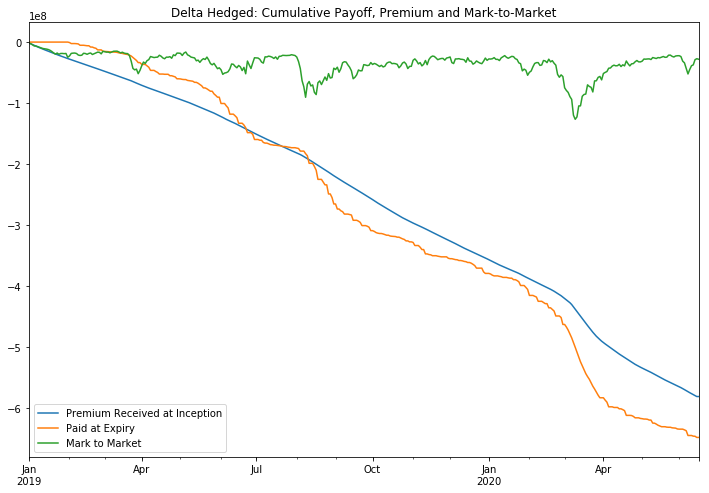

In [12]:
d_hedged = analyze_components(delta_hedged)
d_hedged.plot(figsize=(12, 8), title='Delta Hedged: Cumulative Payoff, Premium and Mark-to-Market')

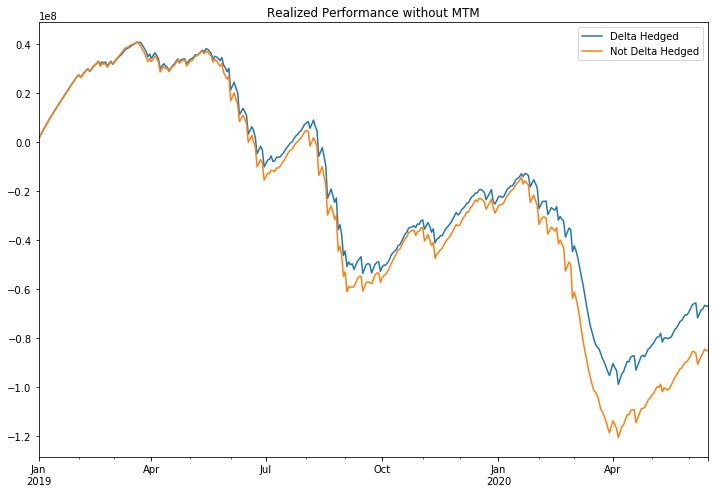

In [13]:
realized_perf = pd.concat([d_hedged['Paid at Expiry']-d_hedged['Premium Received at Inception'],
                           nd_hedged['Paid at Expiry']-nd_hedged['Premium Received at Inception']], 
                           axis=1)
realized_perf.columns = ['Delta Hedged', 'Not Delta Hedged']
realized_perf.plot(figsize=(12, 8), title='Realized Performance without MTM')

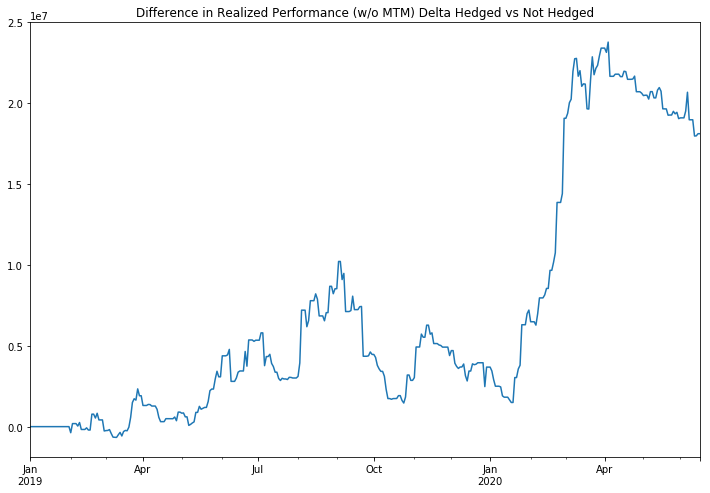

In [14]:
(realized_perf['Delta Hedged']-realized_perf['Not Delta Hedged']).plot(
    figsize=(12, 8), title='Difference in Realized Performance (w/o MTM) Delta Hedged vs Not Hedged')

Looking at the above, delta hedging has generally enhanced the realized performance of this volatility selling strategy especially (unsurprisingly) this year. Let's look at how MTM factors into this.

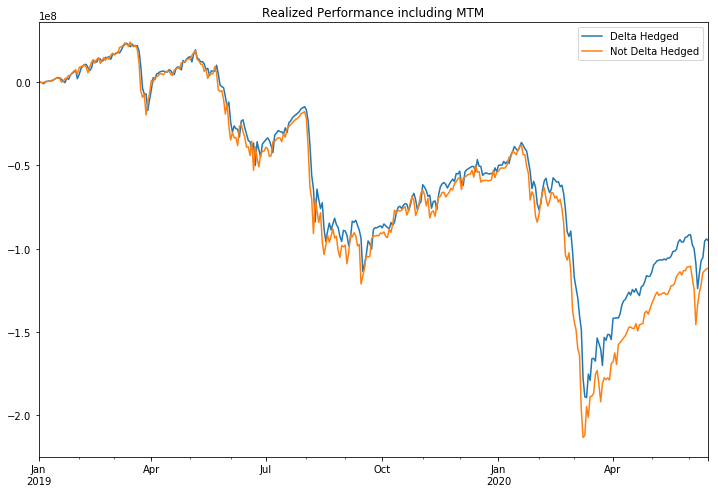

In [15]:
realized_perf_mtm = pd.concat([d_hedged['Paid at Expiry']-d_hedged['Premium Received at Inception']+
                               d_hedged['Mark to Market'],
                              nd_hedged['Paid at Expiry']-nd_hedged['Premium Received at Inception']+
                               nd_hedged['Mark to Market']], axis=1)
realized_perf_mtm.columns = ['Delta Hedged', 'Not Delta Hedged']
realized_perf_mtm.plot(figsize=(12, 8), title='Realized Performance including MTM')

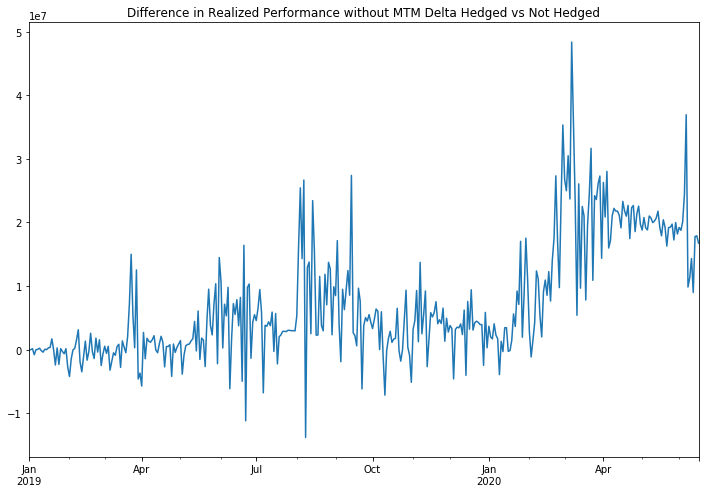

In [16]:
(realized_perf_mtm['Delta Hedged']-realized_perf_mtm['Not Delta Hedged']).plot(
    figsize=(12, 8), title='Difference in Realized Performance without MTM Delta Hedged vs Not Hedged')

The trend is generally the same but with a lot more volatility. 

Note that this backtesting doesn't include transaction costs and the implementation is different from how one might hedge in practice (unwinding and trading a new swap every day) but is economically equivalent to layering the hedges (and is cleaner from a calculation perspective).

Look out for future publications for added transaction costs and ways to quantitatively compare these strategies.